<a href="https://colab.research.google.com/github/QuAAAAA/ML-practice/blob/main/ML%E8%82%A1%E7%A5%A8%E9%A0%90%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

請輸入股票代號:
1234
股票名稱 黑松
         成交股數        成交金額    開盤價    最高價    最低價    收盤價  漲跌價差   成交筆數
0    314759.0  10388065.0  33.00  33.05  32.95  33.00  0.05  145.0
1    209988.0   6928118.0  33.00  33.05  32.95  33.00  0.00   95.0
2    409964.0  13468275.0  32.95  33.10  32.50  32.75 -0.25  221.0
3    102075.0   3357594.0  32.80  32.95  32.80  32.90  0.15   91.0
4    209467.0   6887128.0  32.90  33.00  32.85  33.00  0.10  140.0
..        ...         ...    ...    ...    ...    ...   ...    ...
217   61264.0   2159231.0  35.20  35.30  35.20  35.30  0.00   50.0
218   65968.0   2315291.0  35.25  35.25  35.05  35.15 -0.15   63.0
219  125469.0   4389168.0  35.05  35.10  34.90  34.90 -0.25  104.0
220  167013.0   5807078.0  34.90  34.95  34.70  34.75 -0.15  116.0
221   72309.0   2524998.0  34.75  35.00  34.75  34.80  0.05   60.0

[222 rows x 8 columns]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #

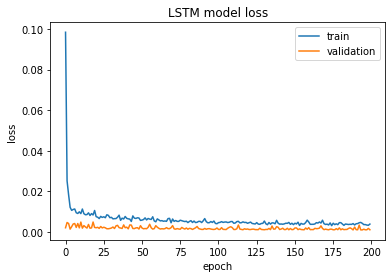

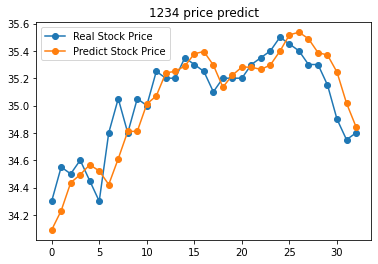

In [ ]:
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as plts
# matplotlib.use('TkAgg')
import numpy as np
import pandas as pd
import requests
from keras.layers import Dense, LSTM
from keras.layers.core import Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras


TWSE_URL = 'http://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json'
train_size, predict_size = 5, 1

scaler = MinMaxScaler(feature_range=(0, 1))
pred_sc = MinMaxScaler(feature_range=(0, 1))


def get_web_content(stock_id, url):
    resp = requests.get(url)
    if resp.status_code != 200:
        return None
    else:
        return resp.json()


def get_data(stock_id):
    info = list()

    for i in range(1, 12):
        url = TWSE_URL + '&date=2021' + "{:0>2d}".format(i) + '01' + '&stockNo=' + stock_id
        resp = get_web_content(stock_id, url)
        time.sleep(5.5)  # 5.5 sec
        if i == 1 :
            if resp['stat'] == "OK":
                name = resp['title'].split(' ')[2]
                print('股票名稱' , name)
            else:
                print("輸入股票代號有誤")
                return False

        for data in resp['data']:
            temp = []
            for j in data[1:]:
                j = j.replace(",", "")
                temp.append(float(j.replace("X", "")))
            info.append(temp)

    df = pd.DataFrame(info)
    df.columns = ["成交股數", "成交金額", "開盤價", "最高價", "最低價", "收盤價", "漲跌價差", "成交筆數"]
    print(df)
    return df

def check_stock_is_exist(stock_id):
    url = TWSE_URL + '&date=2021' + '0101' + '&stockNo=' + stock_id
    resp = get_web_content(stock_id, url)
    time.sleep(2.5)
    if resp['stat'] == "OK":
        return True
    else:
        return False


def window_data(data, window_size):
    X = []
    Y = []
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i + window_size])
        Y.append([data[i + window_size, 0]])
        i += 1
    return np.array(X), np.array(Y)


def data_processor():
    check = False
    print("請輸入股票代號:")
    code = input()
    check = check_stock_is_exist(code)
    while (not check):
        print("股票名稱有誤，請重新輸入:")
        code = input()
        check = check_stock_is_exist(code)


    stock_data = get_data(code)

    data_column = ["收盤價", "成交股數", "成交金額", "開盤價", "最高價", "最低價", "漲跌價差", "成交筆數"]
    dataset = stock_data.loc[:, data_column].values

    dataset_scaled = scaler.fit_transform(dataset)
    price = []
    for i in dataset[:,0]:
        price.append([i])
    pred_sc.fit(np.array(price))

    X, Y = window_data(dataset_scaled, train_size)

    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.15, shuffle=False)  #85% data for traning, 15% data for testing

    return train_X, test_X, train_Y, test_Y , code


def build_train_model():
    train_X, test_X, train_Y, test_Y ,code = data_processor()

    model = Sequential()
    model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(train_Y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mse'])
    print(model.summary())

    result = model.fit(train_X, train_Y, epochs=200, batch_size=16, validation_data=(test_X, test_Y))

    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('LSTM model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.show()

    pred_Y = model.predict(test_X)

    plts.plot(pred_sc.inverse_transform(test_Y) ,'-o', label = 'Real Stock Price')
    plts.plot(pred_sc.inverse_transform(pred_Y),'-o', label='Predict Stock Price')
    plts.title(str(code)+" price predict")
    plt.legend()
    plts.show()
    model.save('hello_world_model.h5')
    return


def run_task():
    build_train_model()





run_task()